### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"

# 2. Total Automation with Lale

Total automation refers to letting AutoML do its search without
manually controlling the search space.
It has the advantage of being simple, requiring only three lines of
code, and can thus be used to get some initial results quickly.

This notebook has the following sections:

- [2.1 Dataset](#2.1-Dataset)
- [2.2 Starting the AutoML Search](#2.2-Starting-the-AutoML-Search)
- [2.3 Inspecting the Trained Pipeline](#2.3-Inspecting-the-Trained-Pipeline)
- [2.4 Regression vs. Classification](#2.4-Regression-vs.-Classification)

## 2.1 Dataset

We will use the
[credit-g](https://www.openml.org/search?type=data&status=active&id=31)
dataset from OpenML for our running example.
Let's fetch it and inspect its size.

In [1]:
import lale.datasets.openml
import lale.helpers
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    "credit-g", "classification", preprocess=False
)
print(f'train_X.shape {train_X.shape}, train_y.shape {train_y.shape}')

train_X.shape (670, 20), train_y.shape (670,)


To get a better feel for the data, we can concatenate the labels and
features.
The labels (class) can be "good" or "bad", so predicting them is a
binary classification task.
The features (checking_status, duration, etc.) include both
categorical and numeric columns.

In [2]:
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.max_columns = None
pd.concat([train_y, train_X], axis=1)

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
863,good,no checking,27.0,critical/other existing credit,furniture/equipment,4526.0,>=1000,<1,4.0,male single,none,2.0,real estate,32.0,stores,own,2.0,unskilled resident,2.0,yes,yes
748,good,no checking,21.0,existing paid,used car,5248.0,no known savings,1<=X<4,1.0,male single,none,3.0,car,26.0,none,own,1.0,skilled,1.0,none,yes
64,good,no checking,24.0,existing paid,radio/tv,3181.0,<100,<1,4.0,female div/dep/mar,none,4.0,life insurance,26.0,none,own,1.0,skilled,1.0,yes,yes
798,good,no checking,24.0,delayed previously,new car,717.0,no known savings,>=7,4.0,male mar/wid,none,4.0,car,54.0,none,own,2.0,skilled,1.0,yes,yes
52,good,no checking,12.0,existing paid,radio/tv,1262.0,<100,1<=X<4,3.0,male single,none,2.0,car,25.0,none,own,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,bad,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,none,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,bad,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,none,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,good,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,none,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,bad,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,none,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes


Let's also print the first dozen ground-truth labels to make the
prediction target more concrete.

In [3]:
print(list(test_y)[:12])

['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'bad']


## 2.2 Starting the AutoML Search

Lale offers total automation with its
[AutoPipeline](https://lale.readthedocs.io/en/latest/modules/lale.lib.lale.auto_pipeline.html#lale.lib.lale.auto_pipeline.AutoPipeline)
operator.
You can use it just like any scikit-learn operator by first
initializing it and then calling `fit`.
The AutoPipeline operator encapsulates a pre-built search space, so
you don't have to hand-edit your own search space.
For demonstration purposes, this notebook uses `max_evals=10`, i.e.,
AutoML internally iterates over 10 trials, sampling and evaluating a
pipeline for each.

In [4]:
from lale.lib.lale import AutoPipeline

In [5]:
trainable_ap = AutoPipeline(max_evals=10)
trained_ap = trainable_ap.fit(train_X, train_y)

After the AutoML search is done, we can use the resulting model by
calling `predict`.
Comparing the predictions to the ground-truth labels earlier in this
notebooks, they are often the same but sometimes deviate, as one would
expect.

In [6]:
y_pred = trained_ap.predict(test_X)
print(list(y_pred)[:12])

['good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good']


We can also use scikit-learn metrics to evaluate the predictive
performance of our model.

In [7]:
from sklearn.metrics import accuracy_score
print(f"accuracy {accuracy_score(test_y, y_pred):.1%}")

accuracy 75.8%


## 2.3 Inspecting the Trained Pipeline

If all you want is for total automation to build you a model, then
this notebook could end here.
However, if you also want to inspect the results of total automation,
read on for some convenient ways to do that.
The `get_pipeline` method returns the best pipeline found during
AutoML search, i.e., the one with the best predictive performance.
And the `visualize` method shows the pipeline as a graph where nodes
are operators and edges represent dataflow.

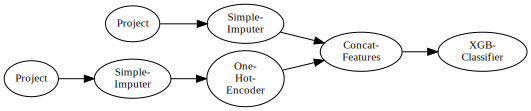

In [8]:
best_found = trained_ap.get_pipeline()
best_found.visualize()

There are two preprocessing pipelines that operate on the same input
pipeline, both starting with a `Project` operator to keep only numeric
columns on one branch and only categorical columns on the other.
Both branches impute missing values, and the branch for categorical
columns one-hot encodes those as numbers.
Finally, the features from both preprocessing pipelines are
concatenated, and `XGBClassifier` predicts the target class.

Depending on your notebook execution environment, the above pipeline
visualization may support tooltips and hyperlinks.
The tooltips, which appear when you hover over an operator, show how
the operator's hyperparameters are configured.
The hyperlinks, which you can follow by clicking on an operator, take
you to its documentation.

Calling `predict` on `best_found` yields the same result as on
`trained_ap`.

In [9]:
y_pred = best_found.predict(test_X)
print(list(y_pred)[:12])
print(f"accuracy {accuracy_score(test_y, y_pred):.1%}")

['good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good']
accuracy 75.8%


You can also print Python source code for the pipeline using
`pretty_print`.
This is useful if you want to inspect the exact details, or if you
want to know how to create a similar pipeline yourself.

In [10]:
best_found.pretty_print(ipython_display=True)

```python
from lale.lib.rasl import Project
import lale.lib.rasl.functions
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from lale.lib.rasl import ConcatFeatures
from xgboost import XGBClassifier
import lale

lale.wrap_imported_operators()
project_0 = Project(
    columns={"type": "number"},
    drop_columns=lale.lib.rasl.functions.categorical(),
)
project_1 = Project(columns=lale.lib.rasl.functions.categorical())
simple_imputer_1 = SimpleImputer(strategy="most_frequent")
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
xgb_classifier = XGBClassifier(verbosity=0)
pipeline = (
    (
        (project_0 >> SimpleImputer())
        & (project_1 >> simple_imputer_1 >> one_hot_encoder)
    )
    >> ConcatFeatures
    >> xgb_classifier
)
```

The above code uses Lale combinators `>>` and `&` for composing
operators in a pipeline.
The pipe combinator (`O1 >> O2`) creates a dataflow edge from operator
`O1` to operator `O2`.
The and combinator (`O1 & O2`) means that both `O1` and `O2` execute
independently on the same data without additional edges between `O1`
and `O2`.
You can pass the argument `combinators=False` to pretty-print to get
back a version of the pipeline that represents the same graph using
scikit-learn functions instead of Lale combinators.

So far, we have only looked at the pipeline with the best score.
The AutoML search also attempted various other candidate pipelines.
You can use the `summary` method to list them

In [11]:
trained_ap.summary()

,loss,time,log_loss,status,tid
name,,,,,
gbt_all,-0.728358,0.480767,0.729399,ok,NaN
p2,-0.707463,1.046207,0.550784,ok,2.0
p1,-0.701493,0.113874,0.570729,ok,1.0
dummy,-0.695522,0.002591,0.616043,ok,NaN
p0,-0.695522,0.128613,0.609503,ok,0.0
p3,-0.695522,0.106378,0.764337,ok,3.0
p4,-0.695522,0.141807,NaN,ok,4.0
p6,-0.694030,0.759701,0.577927,ok,6.0
gbt_num,-0.656716,0.294601,0.846237,ok,NaN


## 2.4 Regression vs. Classification

Most of this tutorial uses the credit-g dataset as a running example,
and thus, focuses on classification.
On the other hand, most of Lale works equally well for regression and
classification.
To get a taste for this, let's look at how to use the AutoPipeline
operator on a regression dataset.

In [12]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)
print(", ".join(f"{y[i]:.1f}" for i in range(10)))

151.0, 75.0, 141.0, 206.0, 135.0, 97.0, 138.0, 63.0, 110.0, 310.0


The main difference to the classification case is that you need to
set `prediction_type="regression"`.

In [13]:
trainable_ap = AutoPipeline(prediction_type="regression", max_evals=10)
trained_ap = trainable_ap.fit(X, y)

After the search, you can use the trained model as usual.

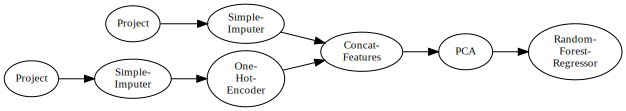

145.4, 74.9, 141.9, 170.9, 121.4, 97.3, 81.6, 167.8, 114.4, 244.5


In [14]:
trained_ap.get_pipeline().visualize()
y_pred = trained_ap.predict(X)
print(", ".join(f"{y_pred[i]:.1f}" for i in range(10)))

The following paper has more information about gradual AutoML and Lale:

```bibtex
@InProceedings{baudart_et_al_2021,
  title = "Pipeline Combinators for Gradual {AutoML}",
  author = "Baudart, Guillaume and Hirzel, Martin and Kate, Kiran and Ram, Parikshit and Shinnar, Avraham and Tsay, Jason",
  booktitle = "Advances in Neural Information Processing Systems (NeurIPS)",
  year = 2021,
  url = "https://proceedings.neurips.cc/paper/2021/file/a3b36cb25e2e0b93b5f334ffb4e4064e-Paper.pdf" }
```